# Exercice 8
Résolvez l'équation d'advection :
$$ \frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} = 0 \quad \forall x \in [0,\infty[ $$

pour une valeur initiale rectangulaire.

-   Implémentez les 5 schémas adaptés et représentez graphiquement la solution pour divers valeur de $t$;
-   Déterminez les conditions de stabilités CFL via le calcul de von Neumann, en considérant l'amplitude $\phi$ comme un nombre complexe, et déterminez si les méthodes sont **principalement** dispersives, dissipatives, ou les deux.

## Solution

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Condition initiale carrée ou sinusoïdale


def u0(x, mode='sin'):
    if mode == 'sin':
        return np.where((x >= 0.0) & (x <= 1.0), np.sin(np.pi * x), 0.0)
    elif mode == 'square':
        return np.where((x >= 0.25) & (x <= 0.75), 1.0, 0.0)


N = 1250  # Nombre de points de discrétisation en espace
L = 10.0  # Longueur du domaine
x = np.linspace(0, L, N+1)  # Maillage en espace
dx = L/N  # Pas d'espace

mode = 'square'

### Upwind et Downwind
Ici, comme $a=1$, seul le schéma upwind est applicable. Pour la stabilité, on a $\lambda \leq 1$ (c.f. slides).

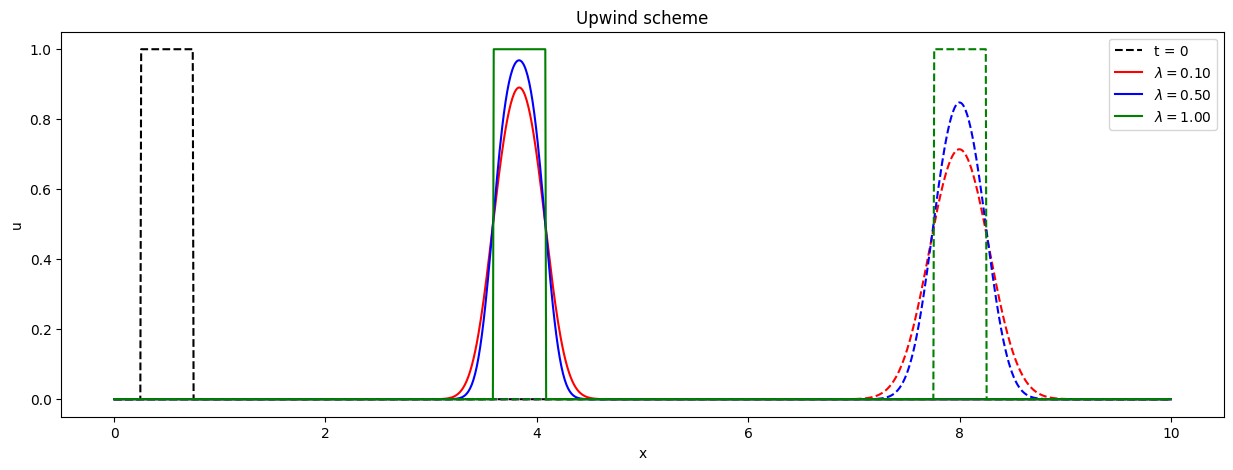

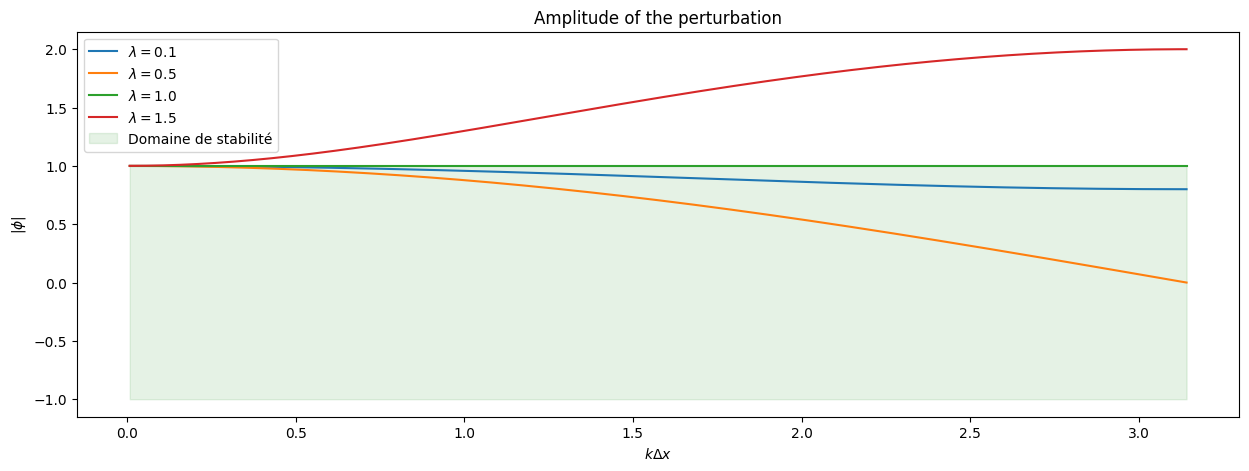

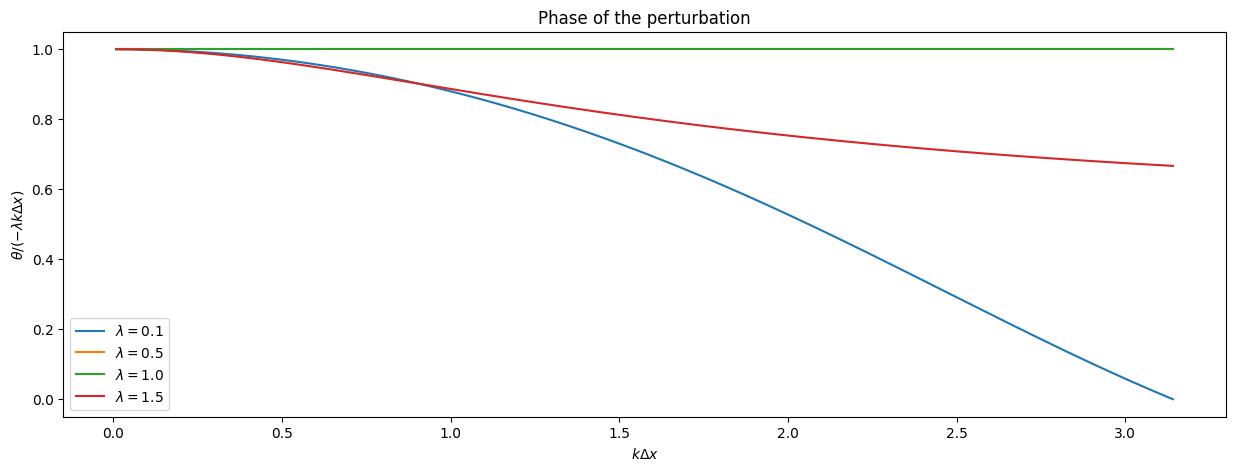

In [2]:
def upwind(x, t_max, lmd, u0_vec):
    dx = x[1] - x[0]
    dt = lmd*dx

    N_t = int(t_max/dt)+1

    t = np.linspace(0, t_max, N_t)
    u = np.zeros((N_t, len(u0_vec)))
    u[0, :] = u0_vec

    for n in range(0, N_t-1):
        u[n+1, :] = (1-lmd)*u[n, :] + lmd*np.concatenate(([0.0], u[n, :-1]))
    return u, t


def plot_upwind():
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(x, u0(x, mode=mode), 'k--', label='t = 0')

    lmb = 0.1
    u, t = upwind(x, 10.0, lmb, u0(x, mode=mode))
    # Plot the solution at 3 different times, including the initial time
    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='r')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='r')

    lmb = 0.5
    u, t = upwind(x, 10.0, lmb, u0(x, mode=mode))

    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='b')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='b')

    lmb = 1.0
    u, t = upwind(x, 10.0, lmb, u0(x, mode=mode))

    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='g')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='g')

    ax.set_title('Upwind scheme')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    plt.show()


plot_upwind()

# Perturbation


def phi(kdx, lmb):
    return 1 - lmb + lmb*np.exp(-1j*kdx)


# Plot |phi(kdx, lmb)|
kdx = np.linspace(dx, np.pi, 1000)

fig_phi, ax_phi = plt.subplots(figsize=(15, 5))

ax_phi.plot(kdx, np.abs(phi(kdx, 0.1)), label='$\lambda = 0.1$')
ax_phi.plot(kdx, np.abs(phi(kdx, 0.5)), label='$\lambda = 0.5$')
ax_phi.plot(kdx, np.abs(phi(kdx, 1.0)), label='$\lambda = 1.0$')
ax_phi.plot(kdx, np.abs(phi(kdx, 1.5)), label='$\lambda = 1.5$')
ax_phi.fill_between(kdx, -1, 1, color='green', alpha=0.1,
                    label='Domaine de stabilité')

ax_phi.set_title('Amplitude of the perturbation')
ax_phi.set_xlabel('$k\Delta x$')
ax_phi.set_ylabel('$|\phi|$')
ax_phi.legend()
plt.show()

fig_theta, ax_theta = plt.subplots(figsize=(15, 5))

ax_theta.plot(kdx, np.angle(phi(kdx, 0.1)) /
              (-0.1*kdx), label='$\lambda = 0.1$')
ax_theta.plot(kdx, np.angle(phi(kdx, 0.5)) /
              (-0.5*kdx), label='$\lambda = 0.5$')
ax_theta.plot(kdx, np.angle(phi(kdx, 1.0)) /
              (-1.0*kdx), label='$\lambda = 1.0$')
ax_theta.plot(kdx, np.angle(phi(kdx, 1.5)) /
              (-1.5*kdx), label='$\lambda = 1.5$')

ax_theta.set_title('Phase of the perturbation')
ax_theta.set_xlabel('$k\Delta x$')
ax_theta.set_ylabel('$ \\theta /(-\lambda k \Delta x)$')
ax_theta.legend()
plt.show()

### Lax-Friedrichs
$$
\begin{align*}
	u^{n+1}_j &= \frac{1}{2}(1-\lambda)u^n_{j+1}+ \frac{1}{2}(1+\lambda)u^n_{j-1}\\
    \Rightarrow \phi &= \frac{1}{2}(1-\lambda)e^{ik\Delta x}+ \frac{1}{2}(1+\lambda)e^{-ik\Delta x}
\end{align*}
$$

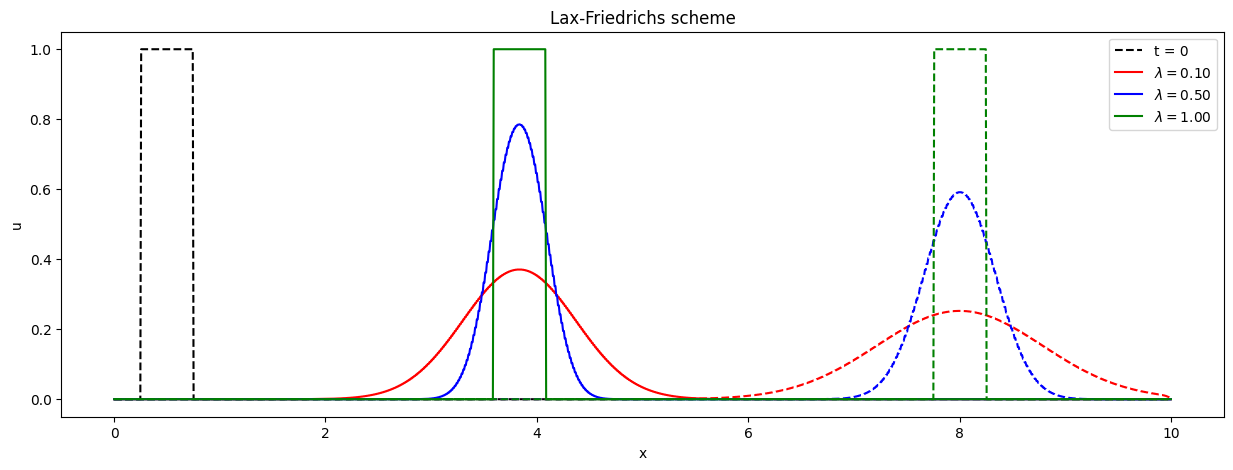

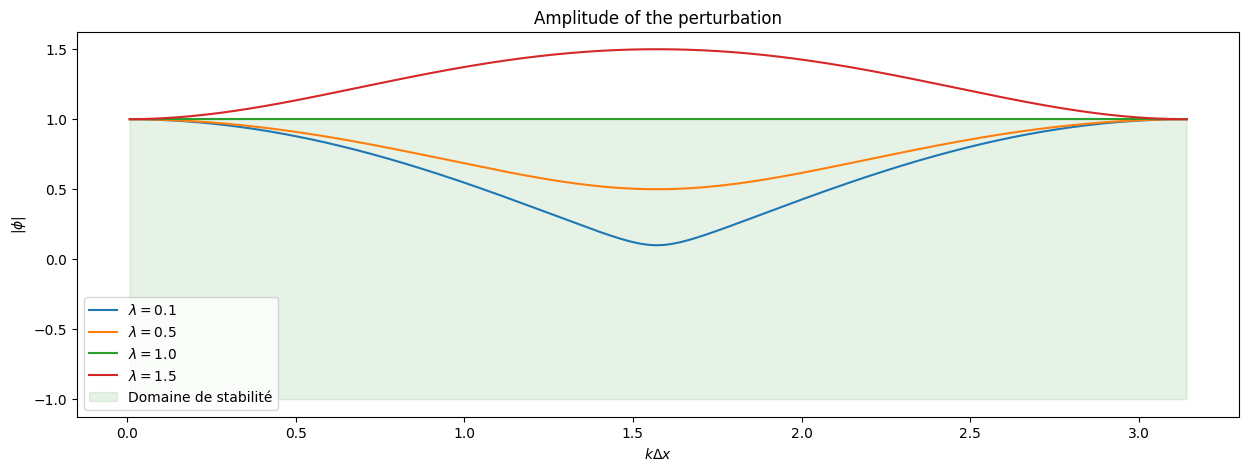

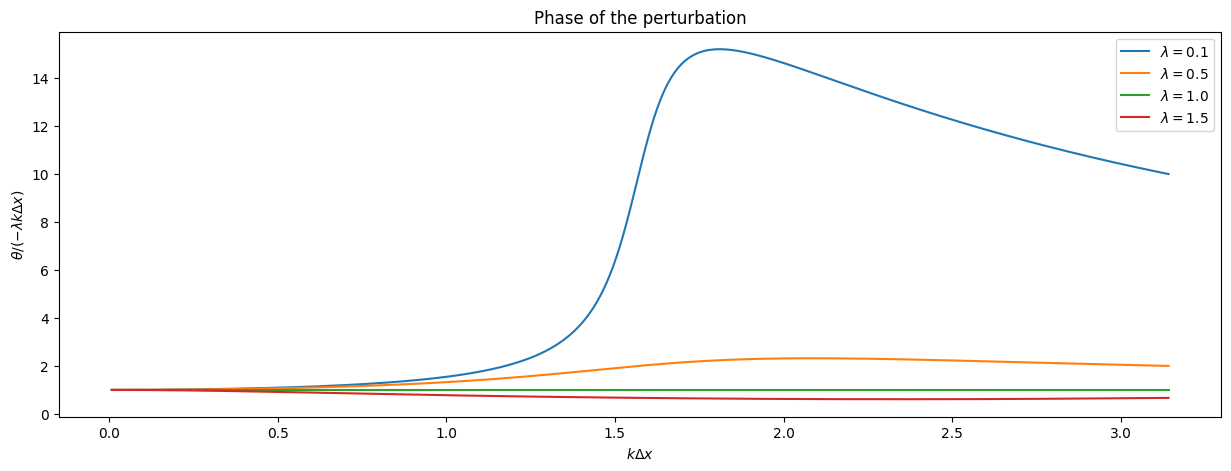

In [3]:
def lax_friedrichs(x, t_max, lmd, u0_vec):
    dx = x[1] - x[0]
    dt = lmd*dx

    N_t = int(t_max/dt)+1

    t = np.linspace(0, t_max, N_t)
    u = np.zeros((N_t, len(u0_vec)))

    u[0, :] = u0_vec

    for n in range(0, N_t-1):
        # or use roll and the domain will be periodic -> beware this may aplify some waves
        u[n+1, :] = 0.5*(1+lmd)*np.concatenate(([0.0], u[n, :-1])) + \
            0.5*(1-lmd)*np.concatenate((u[n, 1:], [0.0]))
    return u, t


def plot_lax_friedrichs():
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(x, u0(x, mode=mode), 'k--', label='t = 0')

    lmb = 0.1
    u, t = lax_friedrichs(x, 10.0, lmb, u0(x, mode=mode))
    # Plot the solution at 3 different times, including the initial time
    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='r')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='r')

    lmb = 0.5
    u, t = lax_friedrichs(x, 10.0, lmb, u0(x, mode=mode))

    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='b')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='b')

    lmb = 1.0
    u, t = lax_friedrichs(x, 10.0, lmb, u0(x, mode=mode))

    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='g')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='g')

    ax.set_title('Lax-Friedrichs scheme')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    plt.show()


plot_lax_friedrichs()

# Perturbation


def phi(kdx, lmb):
    return 0.5*(1-lmb)*np.exp(1j*kdx) + 0.5*(1+lmb)*np.exp(-1j*kdx)


# Plot |phi(kdx, lmb)|
kdx = np.linspace(dx, np.pi, 1000)

fig_phi, ax_phi = plt.subplots(figsize=(15, 5))

ax_phi.plot(kdx, np.abs(phi(kdx, 0.1)), label='$\lambda = 0.1$')
ax_phi.plot(kdx, np.abs(phi(kdx, 0.5)), label='$\lambda = 0.5$')
ax_phi.plot(kdx, np.abs(phi(kdx, 1.0)), label='$\lambda = 1.0$')
ax_phi.plot(kdx, np.abs(phi(kdx, 1.5)), label='$\lambda = 1.5$')
ax_phi.fill_between(kdx, -1, 1, color='green', alpha=0.1,
                    label='Domaine de stabilité')

ax_phi.set_title('Amplitude of the perturbation')
ax_phi.set_xlabel('$k\Delta x$')
ax_phi.set_ylabel('$|\phi|$')
ax_phi.legend()
plt.show()

fig_theta, ax_theta = plt.subplots(figsize=(15, 5))

ax_theta.plot(kdx, np.angle(phi(kdx, 0.1)) /
              (-0.1*kdx), label='$\lambda = 0.1$')
ax_theta.plot(kdx, np.angle(phi(kdx, 0.5)) /
              (-0.5*kdx), label='$\lambda = 0.5$')
ax_theta.plot(kdx, np.angle(phi(kdx, 1.0)) /
              (-1.0*kdx), label='$\lambda = 1.0$')
ax_theta.plot(kdx, np.angle(phi(kdx, 1.5)) /
              (-1.5*kdx), label='$\lambda = 1.5$')

ax_theta.set_title('Phase of the perturbation')
ax_theta.set_xlabel('$k\Delta x$')
ax_theta.set_ylabel('$ \\theta /(-\lambda k \Delta x)$')
ax_theta.legend()
plt.show()

### Leapfrog
$$
\begin{align*}
	u^{n+1}_j &= u^{n-1}_j - \lambda(u^n_{j+1} - u^n_{j-1})\\
    \Rightarrow \phi &= \frac{1}{\phi}-\lambda\left( e^{-ik\Delta x} - e^{ik\Delta x} \right)\\
    \Leftrightarrow \phi &= -i\lambda\sin(k\Delta x) \pm \sqrt{1-\lambda^2\sin^2(k\Delta x)}
\end{align*}
$$

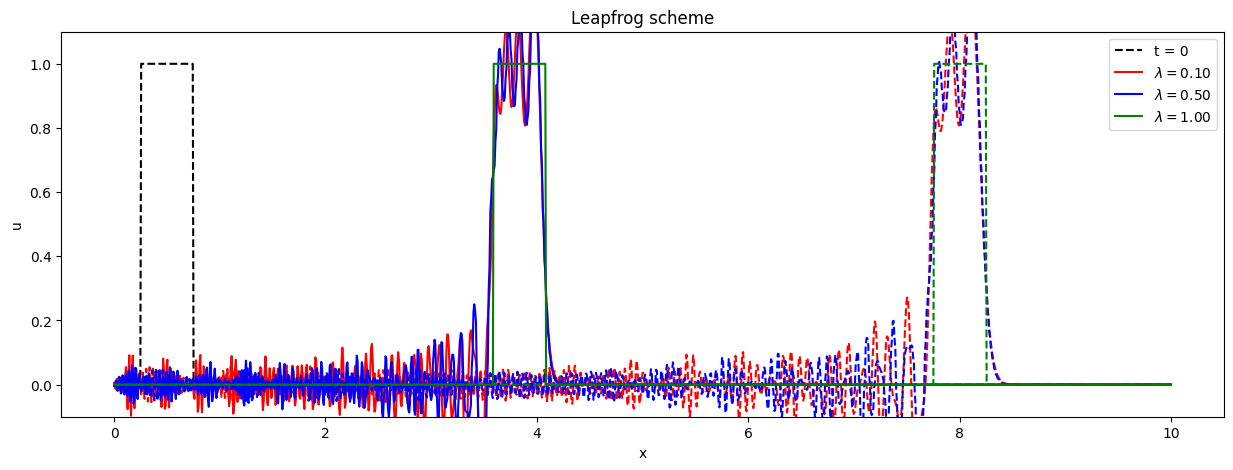

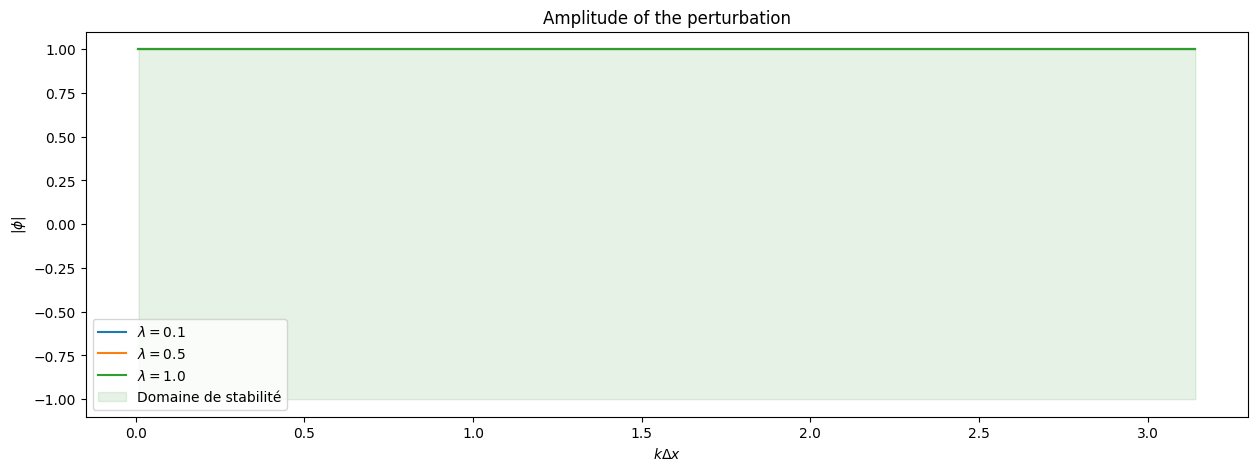

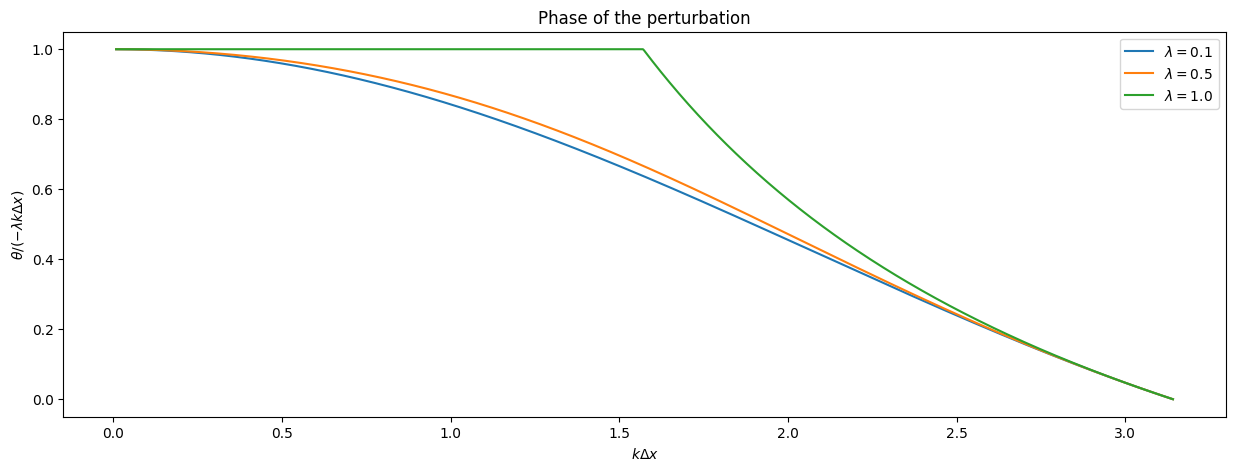

In [4]:
def leapfrog(x, t_max, lmd, u0_vec):
    dx = x[1] - x[0]
    dt = lmd*dx

    N_t = int(t_max/dt)+1

    t = np.linspace(0, t_max, N_t)
    u = np.zeros((N_t, len(u0_vec)))
    u[0, :] = u0_vec

    for n in range(0, N_t-1):
        # Using roll, the domain will be periodic
        if n == 0:  # First step using upwind
            u[n+1, :] = (1-lmd)*u[n, :] + lmd * \
                np.concatenate(([0.0], u[n, :-1]))
        else:
            u[n+1, :] = u[n-1, :] - lmd * \
                (np.concatenate((u[n, 1:], [0.0])) -
                 np.concatenate(([0.0], u[n, :-1])))
    return u, t


def plot_leapfrog():
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(x, u0(x, mode=mode), 'k--', label='t = 0')

    lmb = 0.1
    u, t = leapfrog(x, 10.0, lmb, u0(x, mode=mode))
    # Plot the solution at 3 different times, including the initial time
    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='r')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='r')

    lmb = 0.5
    u, t = leapfrog(x, 10.0, lmb, u0(x, mode=mode))

    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='b')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='b')

    lmb = 1.0
    u, t = leapfrog(x, 10.0, lmb, u0(x, mode=mode))

    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='g')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='g')

    ax.set_title('Leapfrog scheme')
    ax.set_ybound(-0.1, 1.1)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    plt.show()


plot_leapfrog()

# Perturbation


def phi(kdx, lmb):
    return -1j*lmb*np.sin(kdx) + np.sqrt(1-lmb**2*np.sin(kdx)**2+0j)


# Plot |phi(kdx, lmb)|
kdx = np.linspace(dx, np.pi, 1000)

fig_phi, ax_phi = plt.subplots(figsize=(15, 5))

ax_phi.plot(kdx, np.abs(phi(kdx, 0.1)), label='$\lambda = 0.1$')
ax_phi.plot(kdx, np.abs(phi(kdx, 0.5)), label='$\lambda = 0.5$')
ax_phi.plot(kdx, np.abs(phi(kdx, 1.0)), label='$\lambda = 1.0$')
ax_phi.fill_between(kdx, -1, 1, color='green', alpha=0.1,
                    label='Domaine de stabilité')

ax_phi.set_title('Amplitude of the perturbation')
ax_phi.set_xlabel('$k\Delta x$')
ax_phi.set_ylabel('$|\phi|$')
ax_phi.legend()
plt.show()

fig_theta, ax_theta = plt.subplots(figsize=(15, 5))

ax_theta.plot(kdx, np.angle(phi(kdx, 0.1)) /
              (-0.1*kdx), label='$\lambda = 0.1$')
ax_theta.plot(kdx, np.angle(phi(kdx, 0.5)) /
              (-0.5*kdx), label='$\lambda = 0.5$')
ax_theta.plot(kdx, np.angle(phi(kdx, 1.0)) /
              (-1.0*kdx), label='$\lambda = 1.0$')

ax_theta.set_title('Phase of the perturbation')
ax_theta.set_xlabel('$k\Delta x$')
ax_theta.set_ylabel('$ \\theta /(-\lambda k \Delta x)$')
ax_theta.legend()
plt.show()

### Lax-Wendroff
$$
\begin{align*}
	u^{n+1}_j &= -\frac{1}{2}\lambda(1-\lambda)u^n_{j+1}+(1-\lambda^2)u^n_j+\frac{1}{2}\lambda(1+\lambda)u^n_{j-1}\\
    \Rightarrow \phi &= -\frac{1}{2}\lambda(1-\lambda)e^{ik\Delta x}+(1-\lambda^2)+\frac{1}{2}\lambda(1+\lambda)e^{-ik\Delta x}
\end{align*}
$$

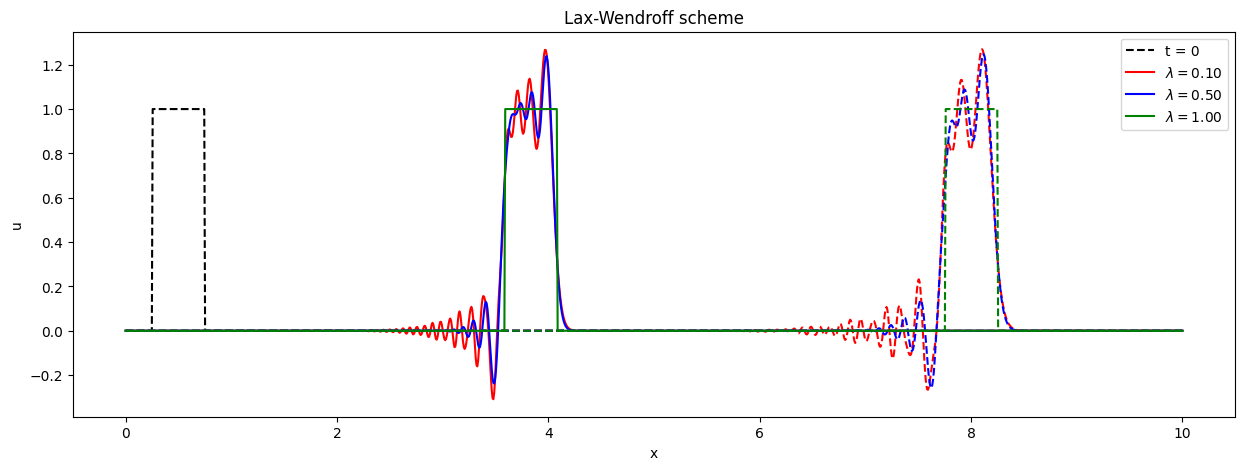

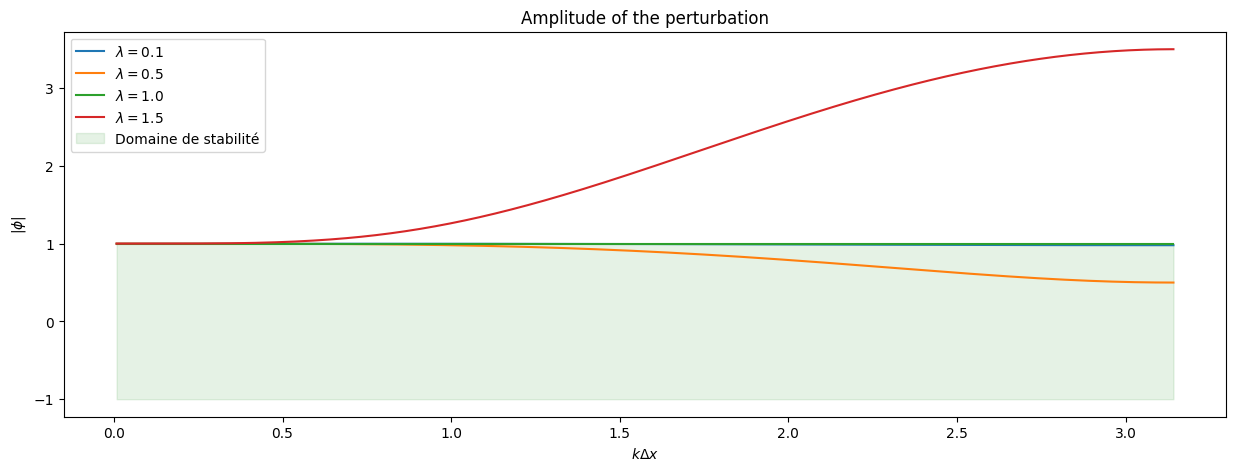

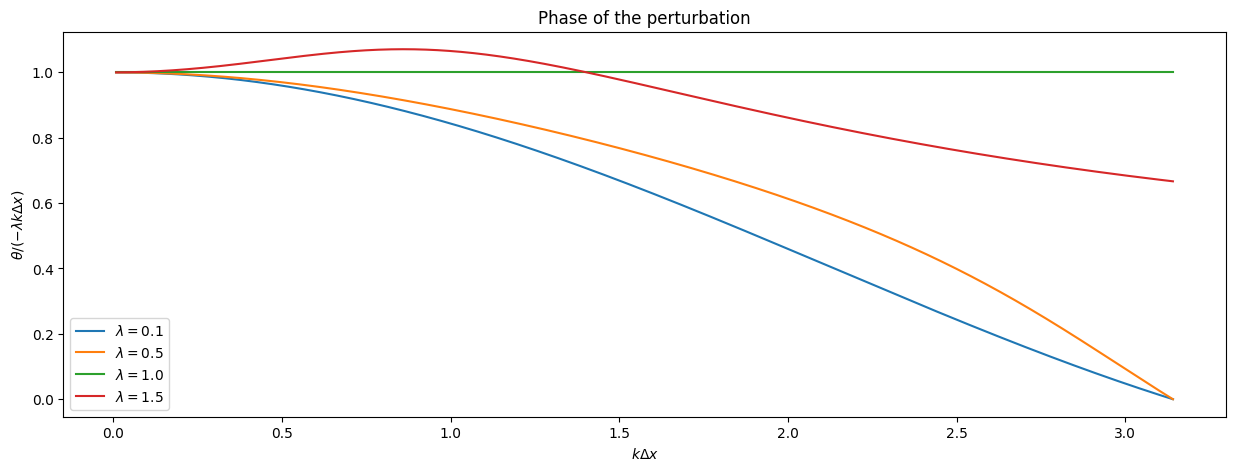

In [5]:
def lax_wendroff(x, t_max, lmd, u0_vec):
    dx = x[1] - x[0]
    dt = lmd*dx

    N_t = int(t_max/dt)+1

    t = np.linspace(0, t_max, N_t)
    u = np.zeros((N_t, len(u0_vec)))

    u[0, :] = u0_vec

    for n in range(0, N_t-1):
        # or use roll and the domain will be periodic -> beware this may aplify some waves
        u[n+1, :] = -0.5*lmd*(1-lmd)*np.concatenate((u[n, 1:], [0.0])) + (
            1-lmd**2)*u[n, :] + 0.5*lmd*(1+lmd)*np.concatenate(([0.0], u[n, :-1]))
    return u, t


def plot_lax_wendroff():
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(x, u0(x, mode=mode), 'k--', label='t = 0')

    lmb = 0.1
    u, t = lax_wendroff(x, 10.0, lmb, u0(x, mode=mode))
    # Plot the solution at 3 different times, including the initial time
    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='r')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='r')

    lmb = 0.5
    u, t = lax_wendroff(x, 10.0, lmb, u0(x, mode=mode))

    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='b')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='b')

    lmb = 1.0
    u, t = lax_wendroff(x, 10.0, lmb, u0(x, mode=mode))

    t1idx = len(t)//3
    ax.plot(x, u[t1idx, :], label='$\lambda = {:.2f}$'.format(lmb), color='g')
    t2idx = 3*len(t)//4
    ax.plot(x, u[t2idx, :], '--', color='g')

    ax.set_title('Lax-Wendroff scheme')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    plt.show()


plot_lax_wendroff()

# Perturbation


def phi(kdx, lmb):
    return -0.5*lmb*(1-lmb)*np.exp(1j*kdx) + (1-lmb**2) + 0.5*lmb*(1+lmb)*np.exp(-1j*kdx)


# Plot |phi(kdx, lmb)|
kdx = np.linspace(dx, np.pi, 1000)

fig_phi, ax_phi = plt.subplots(figsize=(15, 5))

ax_phi.plot(kdx, np.abs(phi(kdx, 0.1)), label='$\lambda = 0.1$')
ax_phi.plot(kdx, np.abs(phi(kdx, 0.5)), label='$\lambda = 0.5$')
ax_phi.plot(kdx, np.abs(phi(kdx, 1.0)), label='$\lambda = 1.0$')
ax_phi.plot(kdx, np.abs(phi(kdx, 1.5)), label='$\lambda = 1.5$')
ax_phi.fill_between(kdx, -1, 1, color='green', alpha=0.1,
                    label='Domaine de stabilité')

ax_phi.set_title('Amplitude of the perturbation')
ax_phi.set_xlabel('$k\Delta x$')
ax_phi.set_ylabel('$|\phi|$')
ax_phi.legend()
plt.show()

fig_theta, ax_theta = plt.subplots(figsize=(15, 5))

ax_theta.plot(kdx, np.angle(phi(kdx, 0.1)) /
              (-0.1*kdx), label='$\lambda = 0.1$')
ax_theta.plot(kdx, np.angle(phi(kdx, 0.5)) /
              (-0.5*kdx), label='$\lambda = 0.5$')
ax_theta.plot(kdx, np.angle(phi(kdx, 1.0)) /
              (-1.0*kdx), label='$\lambda = 1.0$')
ax_theta.plot(kdx, np.angle(phi(kdx, 1.5)) /
              (-1.5*kdx), label='$\lambda = 1.5$')

ax_theta.set_title('Phase of the perturbation')
ax_theta.set_xlabel('$k\Delta x$')
ax_theta.set_ylabel('$ \\theta /(-\lambda k \Delta x)$')
ax_theta.legend()
plt.show()